<a href="https://colab.research.google.com/github/adithyamauryakr/BANDNN_pytorch/blob/main/BANDNN_mirror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install rdkit
!git clone https://github.com/adithyamauryakr/BANDNN_pytorch.git
!git clone https://github.com/isayev/ANI1_dataset.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 56.6 MB/s eta 0:00:00
Cloning into 'BANDNN_pytorch'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 13.66 KiB | 6.83 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Cloning into 'ANI1_dataset'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 81 (delta 6), reused 13 (delta 4), pack-reused 63 (from 1)
Receiving objects: 100% (81/81), 2.69 MiB | 5.01 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [5]:
!export PYTHONPATH="${PYTHONPATH}:/content/ANI1_dataset/readers/lib to PYTHONPATH"

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import lib.pyanitools as pya
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import h5py

features_list = []
with h5py.File('/content/drive/MyDrive/bandnn_datasets/molecules.h5', 'r') as h5f:
    for mol_key in h5f.keys():
        group = h5f[mol_key]
        mol_data = {key: group[key][()] for key in group}
        # Decode bytes to strings if needed
        for k, v in mol_data.items():
            if isinstance(v, bytes):
                mol_data[k] = v.decode('utf-8')
        features_list.append(mol_data)

print(len(features_list))

100000


In [9]:
y = pd.read_csv('/content/drive/MyDrive/bandnn_datasets/energy_list.csv').values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    features_list, y, test_size=0.2, random_state=42
)

In [37]:
# create CustomDataset Class

class BondDataset(Dataset):

  def __init__(self, bond_features, targets):
    self.bond_features = bond_features
    self.targets = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    return self.bond_features[index], self.targets[index]

class AnglesDataset(Dataset):

  def __init__(self, angle_features, targets):

    self.angle_features = angle_features
    self.targets = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    return self.angle_features[index],  self.targets[index]

class NonbondData(Dataset):

  def __init__(self, nonbond_features, targets):
    self.nonbond_features = nonbond_features
    self.targets = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    return self.nonbond_features[index], self.targets[index]

class DihedralData(Dataset):

  def __init__(self, dihedral_features, targets):
    self.dihedral_features = dihedral_features
    self.targets = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    return self.dihedral_features[index], self.targets[index]

In [11]:
# create train_dataset object
X_train_bond_feat = [d['bonds'] for d in X_train]
X_train_angle_feat = [d['angles'] for d in X_train]
X_train_nonbond_feat = [d['nonbonds'] for d in X_train]
X_train_dihedral_feat = [d['dihedrals'] for d in X_train]

X_test_bond_feat = [d['bonds'] for d in X_test]
X_test_angle_feat = [d['angles'] for d in X_test]
X_test_nonbond_feat = [d['nonbonds'] for d in X_test]
X_test_dihedral_Feat = [d['dihedrals'] for d in X_test]

In [12]:
X_train_angle_feat[0].shape, X_train_bond_feat[0].shape

((42, 27), (21, 17))

In [24]:
train_dataset1 = BondDataset(X_train_bond_feat, y_train)
test_dataset1 = BondDataset(X_test_bond_feat, y_test)

train_dataset2 = AnglesDataset(X_train_angle_feat, y_train)
test_dataset2 = AnglesDataset(X_test_angle_feat, y_test)

train_dataset3 = NonbondData(X_train_nonbond_feat, y_train)
test_dataset3 = NonbondData(X_test_nonbond_feat, y_test)

train_trainset4 = DihedralData(X_train_dihedral_feat, y_train)
test_dataset4 = DihedralData(X_test_dihedral_Feat, y_test)

In [25]:
train_loader1 = DataLoader(train_dataset1, batch_size=32, shuffle=True, pin_memory=True)
test_loader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False, pin_memory=True)

train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True, pin_memory=True)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False, pin_memory=True)

train_loader3 = DataLoader(train_dataset3, batch_size=32, shuffle=True, pin_memory=True)
test_loader3 = DataLoader(test_dataset3, batch_size=32, shuffle=False, pin_memory=True)

train_loader4 = DataLoader(train_trainset4, batch_size=32, shuffle=True, pin_memory=True)
test_loader4 = DataLoader(test_dataset4, batch_size=32, shuffle=False, pin_memory=True)

In [15]:
# create CustomDataset Class

class CustomDataset(Dataset):

  def __init__(self, bond_features, angle_features, nonbond_features, dihedral_features, targets):
    self.bond_features = bond_features
    self.angle_features = angle_features
    self.nonbond_features = nonbond_features
    self.dihedral_features = dihedral_features
    self.targets = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return len(self.bond_features)

  def __getitem__(self, index):
    return self.bond_features[index], self.angle_features[index], self.nonbond_features[index], self.dihedral_features[index], self.targets[index]


In [18]:
dataset = CustomDataset(X_train_bond_feat, X_train_angle_feat, X_train_nonbond_feat, X_train_dihedral_feat, y_train)
first_data = dataset[0]
b,a,n,d, labels = first_data
print(len(b[0]),len(a[0]),len(n[0]),len(d[0]), len(labels))

17 27 17 38 1


In [17]:
a = [4]*5

In [70]:
def collate_Fn(batch):
  features_batch = [sample[0] for sample in batch]
  targets_batch = [sample[1] for sample in batch]
  new_feature_list = []
  new_energy_list = []
  for feature, target in zip(features_batch, targets_batch):
    for i in range(len(feature)):
      new_feature_list.append(feature[i])
      new_energy_list.append(target)
  return new_feature_list, new_energy_list

In [75]:
X_train_bond_feat[3].shape

(21, 17)

In [72]:
dataset = BondDataset(X_train_bond_feat, y_train)
train_loader = DataLoader(dataset, batch_size=4, collate_fn=collate_Fn)
for b, t in train_loader:
  print('lengths:',len(b), len(t))

  break

lengths: 76 76


In [26]:
len(b)

21

(array([  295.,   868.,  2618.,  5755.,  7832., 16837., 20639., 25447.,
        14928.,  4781.]),
 array([-471.57122759, -455.4379652 , -439.3047028 , -423.17144041,
        -407.03817801, -390.90491562, -374.77165322, -358.63839082,
        -342.50512843, -326.37186603, -310.23860364]),
 <BarContainer object of 10 artists>)

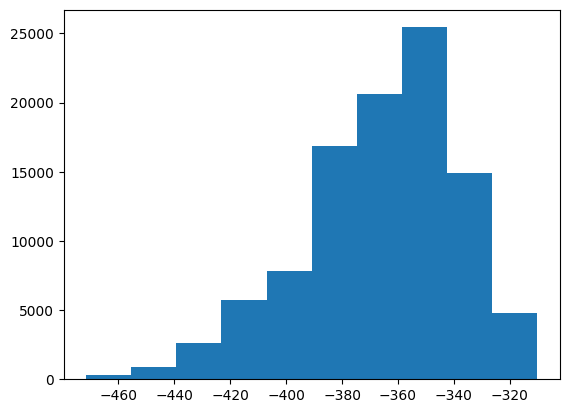

In [14]:
import matplotlib.pyplot as plt

plt.hist(y)

In [28]:
def custom_collate_fn(batch):
    """
    batch: list of 1 or more samples. Each sample is a dict with keys:
      - bonds_input, angles_input, non_bonds_input, dihedrals_input, target_energy
    """
    batch_bonds = [sample['bonds_input'] for sample in batch]
    batch_angles = [sample['angles_input'] for sample in batch]
    batch_nonbonds = [sample['non_bonds_input'] for sample in batch]
    batch_dihedrals = [sample['dihedrals_input'] for sample in batch]
    batch_targets = torch.tensor([sample['target_energy'] for sample in batch], dtype=torch.float32)

    return batch_bonds, batch_angles, batch_nonbonds, batch_dihedrals, batch_targets


In [ ]:
dataloader = DataLoader(dataset, batch_size=4, collate_fn=custom_collate_fn, shuffle=True)

In [13]:
BONDS_DIM, ANGLES_DIM, NONBONDS_DIM, DIHEDRALS_DIM = 17, 27, 17, 38

In [15]:
def make_tensor(seq):
    return torch.tensor(seq, dtype=torch.float32)

In [16]:
class BANDNN(nn.Module):

  def __init__(self, bonds_input_dim, angles_input_dim, nonbonds_input_dim, dihedral_input_dim):
    super().__init__()
    self.bonds_model = nn.Sequential(
        nn.Linear(bonds_input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    self.angles_model = nn.Sequential(
        nn.Linear(angles_input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 350),
        nn.ReLU(),
        nn.Linear(350, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    self.nonbonds_model = nn.Sequential(
        nn.Linear(nonbonds_input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    self.dihedrals_model = nn.Sequential(
        nn.Linear(dihedral_input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

  def forward(self, bonds_input,angles_input, non_bonds_input, dihedrals_input):

    bonds_energy = make_tensor([self.bonds_model(make_tensor(bond_input)) for bond_input in bonds_input])
    angles_energy = make_tensor([self.angles_model(make_tensor(angle_input)) for angle_input in angles_input])
    nonbonds_energy = make_tensor([self.nonbonds_model(make_tensor(non_bond_input))for non_bond_input in non_bonds_input])
    dihedrals_energy =  make_tensor([self.dihedrals_model(make_tensor(dihedral_input)) for dihedral_input in dihedrals_input])
    total_energy =  torch.sum(bonds_energy) + torch.sum(angles_energy) + torch.sum(nonbonds_energy) + torch.sum(dihedrals_energy)

    return total_energy

In [14]:
!pip install torchinfo

In [17]:
from torchinfo import summary
model = BANDNN(17, 27, 17, 38)
model = model.to(device)
# model.summary()
summary(model)

Layer (type:depth-idx)                   Param #
BANDNN                                   --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,304
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33,024
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       32,896
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       129
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       3,584
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      45,150
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      44,928
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      129
├─Sequential: 1-3                        --
│    └─Linear: 2-15                      2,304
│    └─ReLU: 2-16                        --
│    └─Linear: 2-17                      33,

In [18]:
epochs = 20
learning_rate = 0.1

# loss func
criterion = nn.MSELoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
b = torch.tensor(X_train_bond_feat[0], dtype=torch.float32)
a = torch.tensor(X_train_angle_feat[0], dtype=torch.float32)
n = torch.tensor(X_train_nonbond_feat[0], dtype=torch.float32)
d = torch.tensor(X_train_dihedral_feat[0], dtype=torch.float32)

output = model(b, a, n, d)

In [ ]:
output

tensor(3.7860)

In [26]:
for a, b in train_loader4:
  print(a, b)
  break

RuntimeError: stack expects each tensor to be equal size, but got [69, 38] at entry 0 and [54, 38] at entry 1

In [ ]:
# training loop
for epochs in range(epochs):

    total_epoch_loss = 0
    for bond_feat, angle_feat, nonbond_feat, dihedral_feat, energy_feat in train_loader:

        bond_feat = bond_feat.to(device)
        angle_feat = angle_feat.to(device)
        nonbond_feat = nonbond_feat.to(device)
        dihedral_feat = dihedral_feat.to(device)
        energy_feat = energy_feat.to(device)

        outputs = model(bond_feat, angle_feat, nonbond_feat, dihedral_feat)

        loss = criterion(outputs, energy_feat)

        optimizer.zero_grad()

        # back pass
        loss.backward()

        # update params
        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()

    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss: .4f}')

In [ ]:
model.eval()

BANDNN(
  (bonds_model): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (angles_model): Sequential(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=350, bias=True)
    (3): ReLU()
    (4): Linear(in_features=350, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (nonbonds_model): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (dihedra